In [1]:
# Import libraries and packages

# Using PyTorch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models

import matplotlib.pyplot as plt # plot images and graphs
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time

### Use T4 GPU for training the VGG16 model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## VGG-16 
VGG16 is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the popular algorithms for image classification and is easy to use with transfer learning.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg" width="800px"/>

References - 
- [Very Deep Convolutional Networks for Large-Scale Image Recognition - Karen Simonyan, Andrew Zisserman](https://arxiv.org/abs/1409.1556)
- https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
- [VGG MNIST Google Colab Notebook](https://discuss.pytorch.org/t/simple-vgg16-on-mnist-10-classes/127286)

In [3]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

In [4]:
class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [5]:
# Create the model
model = VGG16((1,32,32), batch_norm=True)
# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()

In [6]:
# Let's train the model
def train(loaders, optimizer, criterion, epochs=10, save_param=True, dataset="mnist"):
    global device
    global model
    try:
        model = model.to(device)  # Load model to CUDA

        history_loss = {"train": [], "test": []}
        history_accuracy = {"train": [], "test": []}
        best_test_accuracy = 0  # variable to store the best test accuracy
        
        start_time = time.time()

        for epoch in range(epochs):
            sum_loss = {"train": 0, "test": 0}
            sum_accuracy = {"train": 0, "test": 0}

            for split in ["train", "test"]:
                if split == "train":
                    model.train()
                else:
                    model.eval()
                
                for (inputs, labels) in loaders[split]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()  # Reset gradients
                    prediction = model(inputs)
                    labels = labels.long()
                    loss = criterion(prediction, labels)
                    sum_loss[split] += loss.item()  # Update loss

                    if split == "train":
                        loss.backward()  # Compute gradients
                        optimizer.step()  # Optimize
                    
                    _,pred_label = torch.max(prediction, dim = 1)
                    pred_labels = (pred_label == labels).float()

                    batch_accuracy = pred_labels.sum().item() / inputs.size(0)
                    sum_accuracy[split] += batch_accuracy  # Update accuracy
                    
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split] / len(loaders[split]) for split in ["train", "test"]}
            epoch_accuracy = {split: sum_accuracy[split] / len(loaders[split]) for split in ["train", "test"]}

            # Store params at the best test accuracy
            if save_param and epoch_accuracy["test"] > best_test_accuracy:
                torch.save(model.state_dict(), f"/kaggle/temp/vgg16_{dataset}_model.pth")
                best_test_accuracy = epoch_accuracy["test"]

            # Update history
            for split in ["train", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            print(f"Epoch: [{epoch + 1} | {epochs}]\nTrain Loss: {epoch_loss['train']:.4f}, Train Accuracy: {epoch_accuracy['train']:.2f}, \
            Test Loss: {epoch_loss['test']:.4f}, Test Accuracy: {epoch_accuracy['test']:.2f}, Time Taken: {(time.time() - start_time) / 60:.2f} mins")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

## MNIST Dataset
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 

(Taken from - http://yann.lecun.com/exdb/mnist/)



In [7]:
# Compose transformations
transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
])

# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root='/kaggle/temp', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='/kaggle/temp', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 111912482.96it/s]


Extracting /kaggle/temp/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47226391.35it/s]


Extracting /kaggle/temp/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27162045.58it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8604574.87it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



In [8]:
# Now let's analyze the dataset
print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

# Extract data and targets
x_train, y_train = train_set.data, train_set.targets

# Add a dimension to the tensor to become B*C*H*W
if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)
print(x_train.shape)

Number of training samples: 60000
Number of test samples: 10000
torch.Size([60000, 1, 28, 28])


torch.Size([3, 152, 242])


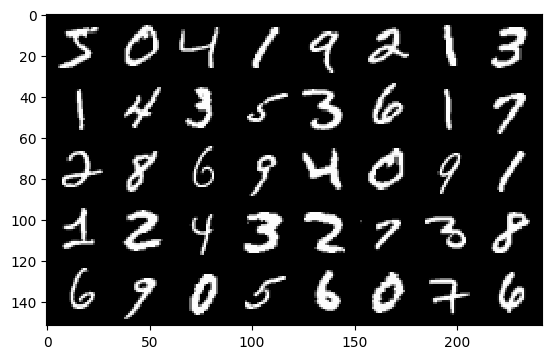

In [9]:
# Make a grid of 40 images, 8 images per row
x_grid = torchvision.utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)

# Convert tensor to numpy array
npimg = x_grid.numpy()
# Convert to H*W*C shape
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg_tr, interpolation='nearest')

Label: 1


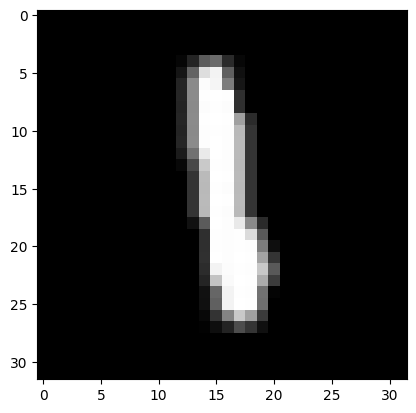

In [10]:
image, label = train_set[200]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [11]:
# Set up data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "test": test_loader}

Epoch: [1 | 10]
Train Loss: 1.2214, Train Accuracy: 0.67,             Test Loss: 0.2120, Test Accuracy: 0.96, Time Taken: 0.62 mins
Epoch: [2 | 10]
Train Loss: 0.2039, Train Accuracy: 0.95,             Test Loss: 0.0754, Test Accuracy: 0.98, Time Taken: 1.15 mins
Epoch: [3 | 10]
Train Loss: 0.1087, Train Accuracy: 0.97,             Test Loss: 0.0529, Test Accuracy: 0.98, Time Taken: 1.67 mins
Epoch: [4 | 10]
Train Loss: 0.0783, Train Accuracy: 0.98,             Test Loss: 0.0421, Test Accuracy: 0.99, Time Taken: 2.21 mins
Epoch: [5 | 10]
Train Loss: 0.0626, Train Accuracy: 0.98,             Test Loss: 0.0345, Test Accuracy: 0.99, Time Taken: 2.73 mins
Epoch: [6 | 10]
Train Loss: 0.0525, Train Accuracy: 0.99,             Test Loss: 0.0299, Test Accuracy: 0.99, Time Taken: 3.26 mins
Epoch: [7 | 10]
Train Loss: 0.0438, Train Accuracy: 0.99,             Test Loss: 0.0277, Test Accuracy: 0.99, Time Taken: 3.78 mins
Epoch: [8 | 10]
Train Loss: 0.0382, Train Accuracy: 0.99,             Test L

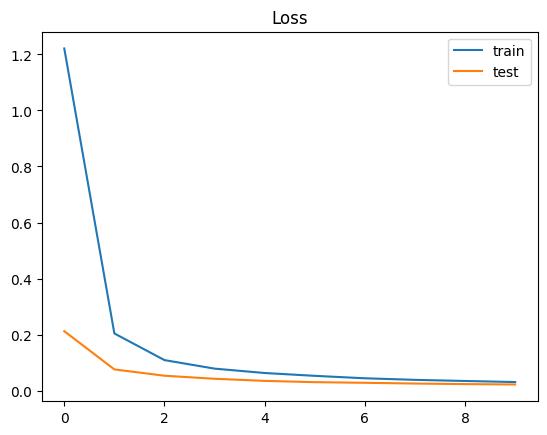

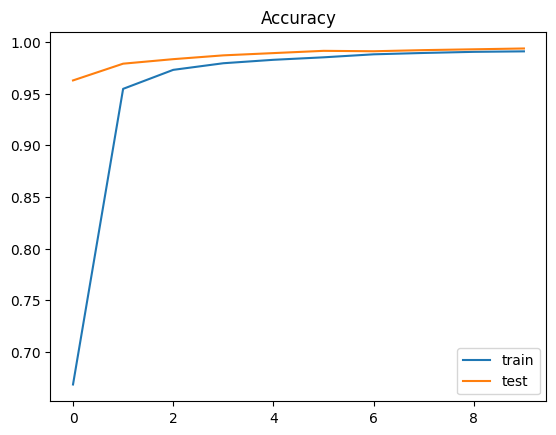

In [12]:
# Train model on MNIST Dataset
train(loaders, optimizer, criterion, epochs=10)

## Fashion-MNIST Dataset
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Source - https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [13]:
# Compose transformations
transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
])

# Load MNIST dataset with transforms
train_set = torchvision.datasets.FashionMNIST(root='/kaggle/temp', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='/kaggle/temp', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 18999010.11it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304272.73it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5465255.59it/s]


Extracting /kaggle/temp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10855845.65it/s]

Extracting /kaggle/temp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



In [14]:
# Now let's analyze the dataset
print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

# Extract data and targets
x_train, y_train = train_set.data, train_set.targets

# Add a dimension to the tensor to become B*C*H*W
if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)
print(x_train.shape)

Number of training samples: 60000
Number of test samples: 10000
torch.Size([60000, 1, 28, 28])


torch.Size([3, 152, 242])


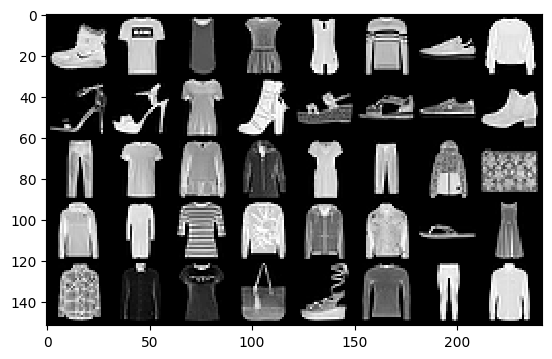

In [15]:
# Make a grid of 40 images, 8 images per row
x_grid = torchvision.utils.make_grid(x_train[:40], nrow=8, padding=2)
print(x_grid.shape)

# Convert tensor to numpy array
npimg = x_grid.numpy()
# Convert to H*W*C shape
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg_tr, interpolation='nearest')

Label: 8


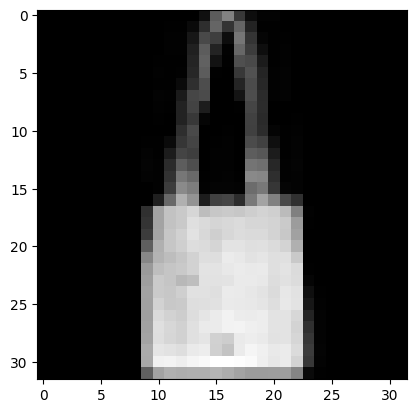

In [16]:
image, label = train_set[200]
plt.imshow(image.squeeze(), cmap='gray')
print('Label:', label)

In [17]:
# Set up data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "test": test_loader}

Epoch: [1 | 10]
Train Loss: 0.5844, Train Accuracy: 0.80,             Test Loss: 0.3839, Test Accuracy: 0.87, Time Taken: 0.53 mins
Epoch: [2 | 10]
Train Loss: 0.3663, Train Accuracy: 0.87,             Test Loss: 0.3496, Test Accuracy: 0.87, Time Taken: 1.06 mins
Epoch: [3 | 10]
Train Loss: 0.3087, Train Accuracy: 0.89,             Test Loss: 0.3312, Test Accuracy: 0.88, Time Taken: 1.59 mins
Epoch: [4 | 10]
Train Loss: 0.2721, Train Accuracy: 0.91,             Test Loss: 0.2912, Test Accuracy: 0.90, Time Taken: 2.12 mins
Epoch: [5 | 10]
Train Loss: 0.2461, Train Accuracy: 0.91,             Test Loss: 0.2821, Test Accuracy: 0.90, Time Taken: 2.65 mins
Epoch: [6 | 10]
Train Loss: 0.2219, Train Accuracy: 0.92,             Test Loss: 0.2723, Test Accuracy: 0.90, Time Taken: 3.18 mins
Epoch: [7 | 10]
Train Loss: 0.2021, Train Accuracy: 0.93,             Test Loss: 0.2832, Test Accuracy: 0.90, Time Taken: 3.70 mins
Epoch: [8 | 10]
Train Loss: 0.1815, Train Accuracy: 0.94,             Test L

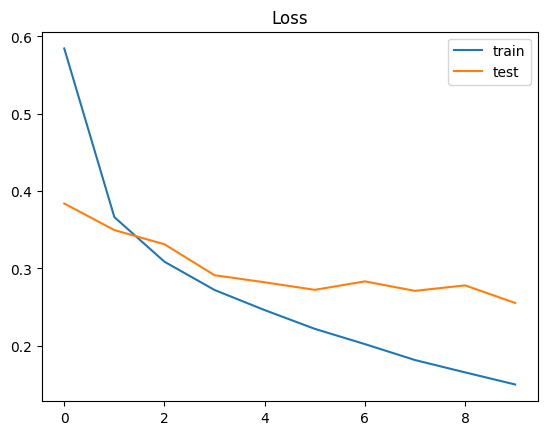

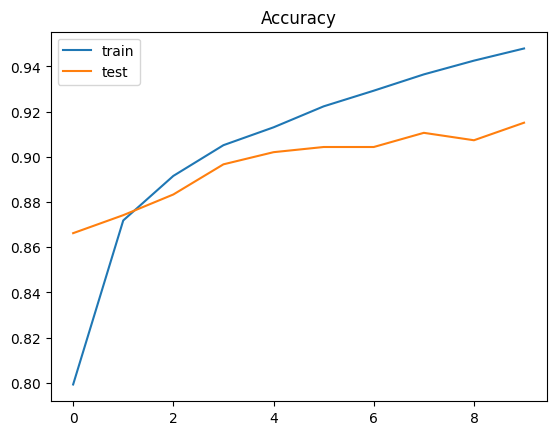

In [18]:
# Train model on Fashion-MNIST Dataset
train(loaders, optimizer, criterion, epochs=10, dataset='fashion-mnist')